 Allenare un modello di image-classification utilizzando pochi dati è una situazione comune. Ovviamente il "poco" è relativo, dipende dal problema. A volte con poco si intendono centinaia di immagini, altre volte decine di migliaia.

 In questo esempio pratico lavoreremo su un dataset composto da 5.000 immagini di cani e gatti (2.500 cani e 2.500 gatti - dataset perfettamente bilanciato.). Utilizzeremo 2.000 immagini per il training, 1.000 per la validazione e 2.000 per il testing. Il dataset non è presente in keras, ma è stato definito da Kaggle nel 2013 per una competizione di image classification. [link del dataset](https://www.kaggle.com/c/dogs-vs-cats/data).

 Il dataset originale contiene 50.000 immagini totali, ma noi lavoreremo solo su un sottoinsieme di 5.000 immagini. Perchè non sfruttare tutto il dataset? Perchè nella maggior parte dei casi reali si hanno dataset piccoli, con centinaia/poche migliaia di immagini. Quindi avere un dataset grande come in questo caso renderebbe il problema molto più semplice, quindi meglio imparare partendo da una situazione più "scomoda".

In [1]:
!unzip -qq train.zip

Definiamo il codice per creare il nostro sotto-dataset di 5.000 immagini totali considerando il dataset originale. Una volta eseguito il codice il sotto-dataset avrà la seguente struttura: \\
**cats_vs_dogs_small/** \\
.**train/** \\
..cat/ contiene 1.000 immagini di gatti \\
..dog/ contiene 1.000 immagini di cani \\
.**validation/** \\
..cat/ contiene 500 immagini di gatti \\
..dog/ contiene 500 immagini di cani \\
.**test/** \\
..cat/ contiene 1.000 immagini di gatti \\
..dog/ contiene 1.000 immagini di cani \\

In [2]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
  for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]

    for fname in fnames:
      shutil.copyfile(src=original_dir / fname,
      dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

Adesso abbiamo 2.000 immagini di training, 1.000 di validation e 2.000 di testing. Ogni split contiene lo stesso numero di immagini per entrambi le classe, in modo da avere un problema di classificazione binaria **perfettamente bilanciato.** L'etichetta delle immagini contenenti cani è 1, mentre quella con i gatti 0.

Una volta che abbiamo a disposizione i dati, passiamo direttamente con la **costruzione del nostro modello**, o meglio, **la nostra baseline**. Infatti, trattandosi di un nuovo task, e stiamo affrontando per la prima volta questo problema, è buona norma proporre, come prima soluzione, una baseline. \\
Una modello baseline ha vari scopi, infatti, può essere utilizzato sia come modello di "base", sia utilizzato come soglia per accettare nuove soluzioni. **Lo si può vedere come il modo "più semplice" per risolvere il problema, in quando non si effettua ne data pre-processing, ne tantomeno si utilizzano modelli complessi**. Lo si utilizza come primo approccio al problema, per vedere il risultato che si ottiene sui dati.

Di conseguenza definiamo la nostra baseline, che corrisponde ad una CNN composta solo da Layer di Convulazione e di Max Pooling, con ovviamente, un layer di appiattimento "Flatten" per trasformare la feature map in un vettore (tensore 1D) in modo che possa essere processato da un layer Dense che lavora solo su vettori.

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)



*  Le immagini di input sono 180x180 RGB (3 canali), di conseguenza, definiamo l'imput del modello con shape 180x180,3
*   Trattandosi di immagini RGB, i valori associabile ai singoli pixel si trovano nell'intervallo [0,255]. Generalmente, è preferibile normalizzare questo intervallo portandolo all'intervallo [0,1]. Di conseguenza, immediatamente dopo l'input, andiamo a definire un layer di Rescaling, nel quale dividiamo per 255 in modo da portare i pixel nell'intervallo [0,1]
*  Trattandosi di una baseline, definiamo una semplice CNN, quindi utilizziamo una sequenza di layer Convulazionali e di Max Pooling.

**Una domanda che ci si potrebbe porre proprio in riferimento ai layer di Convulazione è: Perchè il numero dei filtri applicate sulle immagini aumenta man mano che va avanti nella rete? Quindi come mai i filtri applicati aumentano con il diminuire della dimensione delle immagini?**

1) La risposta è che i primi layer della rete generalmente catturano delle caratteristiche più semplici, es: bordi, colori, angoli, etc.., di conseguenza bastano pochi filtri per catturare ed estrarre queste feature basilari. \\


2) I layer più profondi si occupano di feature più complesse e astratte: forme, oggetti, strutture. Servono quindi più filtri (es. 64, 128, 256) per poter rappresentare un numero maggiore di combinazioni e complessità. \\


3) Inoltre, man mano che vai più in profondità:
Le dimensioni spaziali (altezza/larghezza) dell'immagine si riducono con il pooling.Per compensare questa perdita e mantenere ricchezza di informazione, si aumentano il numero dei canali (filtri).



In [4]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

**Trattandosi di una classificazione binaria, utilizzeremo la binary_crossentropy piuttosto che la categorical.**

In [5]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Come sappiamo, **i dati che devono essere dati in input al modello devono avere un formato appropriato, cioè dei tensori float.** Ma al momento abbiamo dei file JPEG sul drive. Di conseguenza, **bisogna effettuare le seguenti operazioni per trasformare quste immagini JPEG in dei dati da dare in input al nostro modello:**


1.   Leggere i file delle immagini
2.   Trasformare le immagini in delle matrici di pixel RGB
3. Convertire queste matrici in dei tensori float
4. ridimensionarle in una dimensione comune (180x180 in questo caso)
5. raggruppare le immagini in dei batch (32 in questo caso - ogni batch sarà composta da 32 immagini).

Fortunatamente tutte queste operazioni sono applicate automaticamente tramite la funzione image_dataset_from_directory(), che permette di definire una pipeline automatica che converte le immagini sul disco in dei batch di tensori pre-processati.



In [6]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


**Il metodo restituisce un oggetto Dataset: composto da batches di 32 immagini RGB 180x180 ciascuno (32, 180, 180, 3) e delle label di interi (vettori di 32 numeri - tensore 1D - quind shape = (32,))** \\
Infatti, iterando sull'oggetto Dataset (è iterabile), possiamo accedere ai singoli batch, sia delle immagini che delle loro labels:

In [7]:
for data_batch, labels_batch in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Passiamo con l'allenamento e la validation del modello.

Utilizziamo anche **Callbacks: rappresenta un oggetto che permette di effettuare delle azioni durante la fase di training del modello**, es: all'inizio o alla fine di ogni epoca o batch, etc...

**Le azioni vengono passate come una lista di oggetti Callbacks. In questo caso utilizziamo la callback per salvare il miglior modello al termine di ogni epoca.** Di base, il ModelCheckpoint() callback salva il modello al termine di ogni epoca, ma, impostando il parametro save_best_only = True e monitor = val_loss, **il modello verrà salvato (sovrascrivendo quello precedente) solo se il valore della val_loss è minore rispetto a quello precedente**. **Questo garantisce, che al termine del training, venga salvato il miglior modello** (quello con val_loss più basso). Questo permette, in caso di overfitting del modello, di accedere al modello migliore, cioè quello generato prima dell'overfitting (quindi non c'è bisogno di allenare un nuovo modello per un numero minore di epoche per evitare l'overfitting)


In [8]:
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch.keras",
    save_best_only=True,
    monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - accuracy: 0.5032 - loss: 0.6991 - val_accuracy: 0.6020 - val_loss: 0.6918
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.5537 - loss: 0.6916 - val_accuracy: 0.5010 - val_loss: 0.6887
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.5841 - loss: 0.6762 - val_accuracy: 0.6670 - val_loss: 0.6389
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6485 - loss: 0.6437 - val_accuracy: 0.5820 - val_loss: 0.6818
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6775 - loss: 0.5915 - val_accuracy: 0.6250 - val_loss: 0.6417
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7088 - loss: 0.5660 - val_accuracy: 0.6530 - val_loss: 0.6198
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.7395 - loss: 0.5320 - val_accuracy: 0.6730 - val_loss: 0.6175
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7646 - loss: 0.4975 - val_accuracy: 0.7110 -

**Una volta allenato il modello, plottiamo le curve di Loss e Accuracy**

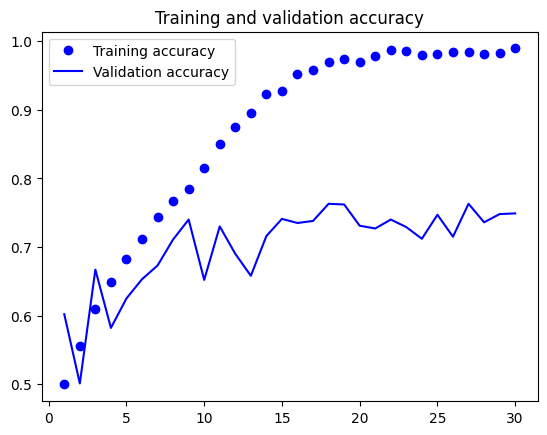

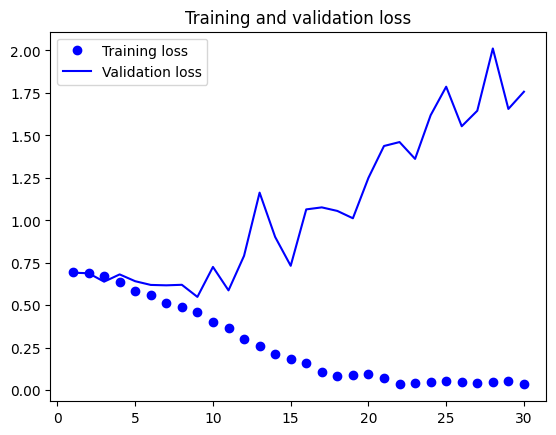

In [9]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Osservando i grafici, si può notare un'andamento a "forbice" con il passare delle epoche. Cioè, le due linee, con il passare delle epoche, tendono sempre di più ad allontanarsi, quindi, ad aprirsi, formando una specie di "forbice". Questo è un chiaro segno di **Overfitting** da parte del modello. Infatti,** l'accuracy sul training** set aumenta linearmente durante le epoche, fino a **raggiungere** addirittura il **100%**. Mentre, **l'accuracy del validation set raggiunge** al massimo il circa **75%** (c'è troppa differenza, overfitting). Ragionando sulla validation loss, si può notare che il **minimo si raggiunge verso la 9/10 epoca**, e da li in poi, la loss va in uno stato di **stallo**.

Avendo salvato il modello migliore (con la minor val_loss), possiamo caricarlo nel nostro workspace per testarlo e/o fare delle prediction. In Questo caso, per **capire l'accuracy del nostro modello su dei dati mai visti**, lo utilizzeremo dandogli in input il test set:

In [10]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)

print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7294 - loss: 0.5580
Test accuracy: 0.724


Otteniamo un'accuracy del circa 72%. Consideriamo quindi questo modello appena allenato e testato, come la nostra baseline da "battere".

Visto che abbiamo allenato il modello con un training set molto piccolo (2.000 immagini), **il nostro problema principale sarà quello di combattere contro l'overfitting** (come già visto all'interno della baseline). Tuttavia, sappiamo che esistono varie tecniche per "combatterlo", come il **droput e/o la L2 Regularization**. Tuttavia, esiste un'altro metodo, specifico per il contesto della Computer Vision, e che viene utilizzato in maniera universale quando si processano immagini con modelli di depep Learning: **Data Augmentation.**

**Questo perchè nelle CNN, il droput non è sempre la scelta migliore, **soprattutto nei Layer Convulazionali, **in quanto può creare disturbo nell'apprendimento di feature locali (pixel vicini)**. Al massimo, lo si può utilizzare alla fine della CNN (**Dopo il layer di flatten o il dense layer finale.), ma non dopo un layer Convulazionale.**

**La tecnica preferita per combattere l'overfitting nel contesto di computer vision è la Data Augmentation**. Essa risolve il problema dalla base, cioè, l'overfitting, nella maggior parte dei casi è causato da una quantità insufficiente di immagini di training; cioè, il modello, impara solo da una piccola quantità di immagini, ricoprendo solo una piccolissima parte di tutte le possibili immagini che potrebbe ricevere, quindi ha problemi di generalizzazione. Ma, se aumentassimo sempre di più il numero di immagini (diverse) che riceve durante l'allenamento, il modello verrà esposto man mano a sempre più dati rispetto al totale, facendo diminuire il problema di generalizzazione.
**La data augmentation è una tenica che si basa proprio su questo principio, cioè, creare immagini nuove e diverse di training partendo da quelle che si hanno già a disposizione, applicando delle trasformazioni e modifiche casuali in modo da aumentare il numero di immagini di training a cui il modello sarà esposto a più aspetti dei dati, in modo da generalizzare meglio.**

In [11]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
  ]
)

**In keras, è possibile applicare la data augmentation aggiungendo uno o più layer di Data Augmentation all'inizio del modello in modo da ricevere in input il training set, aumentare il numero di samples effettuando trasformazioni e successivamente darlo in input al modello come nuovo training set esteso.**

Questi sono vari layer che si possono utilizzare, ma ne esistono molti altri. In questo caso cosa fanno questi layer e perchè si definiscono dei numeri all'interno di alcuni layer?



*   **RandomFlip("Horizontal"):** Applica una rotazione orizzontale al 50% delle immagini che riceverà in input
*   **RandomRotation(0.1):** Ruota l'immagine in input con un valore randomico nel range [-10%,+10%]
*  **RandomZoom(0.2):** fa uno zoom in/out su un immagine con un fattore casuale del [-20%,+20%]

Mostriamo un esempio di immagini a cui sono state applicate questi layer:

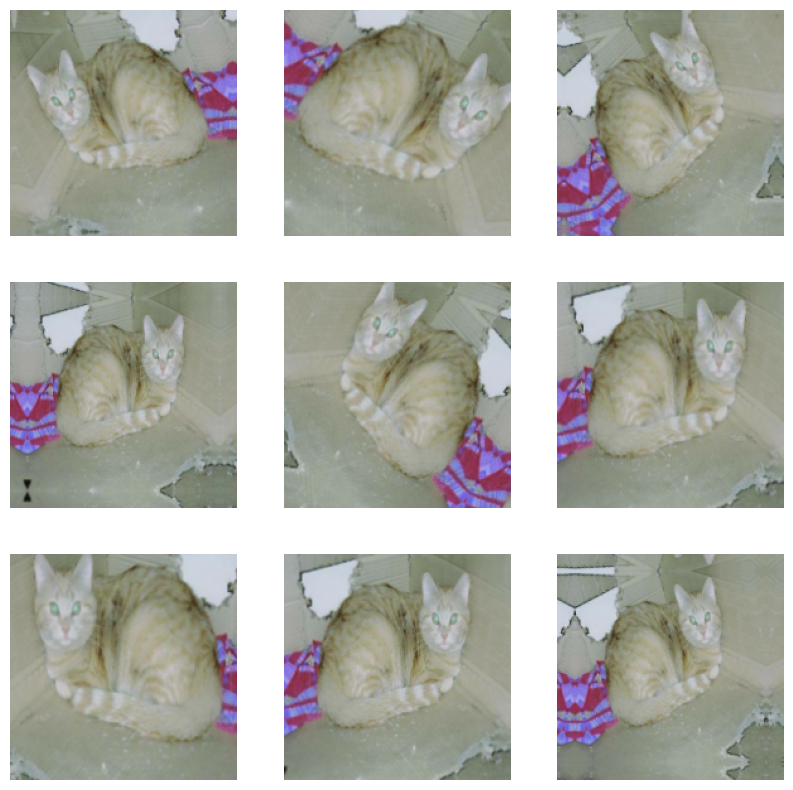

In [12]:
plt.figure(figsize=(10, 10))

for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

**Le immagini non sono mai le stesse, sono simili, ma non uguali.**

Infatti, allenando un nuovo modello con questa configurazione di data augmentation, il modello non vedrà MAI durante la fase di training un'immagine per più di una volta (grave cosa quando si allenano dei modelli). Tuttavia, le immagini, sono altamente interconnesse tra di loro in quanto sono state prodotte partendo da un un set di training piccolo, quindi saranno comunque simili tra di loro. Questo perchè noi NON POSSIAMO PRODURRE NUOVE INFORMAZIONI; ma, possiamo solo MIXARE QUELLE GIà ESISTENTI.

Visto che utilizzare solo questa tecnica non ci porta a risolvere l'overfitting del tutto, possiamo anche utilizzare la tecnica del Droput, aggiungendolo dopo il layer di appiattimento (flatten), ma prima del layer denso che si occupa della classificazione:

In [13]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
optimizer="rmsprop",
metrics=["accuracy"])

Questo è il nostro modello finale, con aggiunta sia della data augmentation che del dropout. Possiamo passare all'allenamento: in questo caso, visto che utilizziamo delle tecniche per combattere l'overfitting, **ci aspettiamo che il modello vada in overfitting più tardi rispetto prima, quindi triplichiamo il numero di epoche, considerandone 100**

In [14]:
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch_with_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")
  ]

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.5085 - loss: 0.7082 - val_accuracy: 0.5000 - val_loss: 0.7424
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.5371 - loss: 0.6989 - val_accuracy: 0.6360 - val_loss: 0.6853
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.5860 - loss: 0.6812 - val_accuracy: 0.5060 - val_loss: 0.6870
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.5955 - loss: 0.6671 - val_accuracy: 0.6420 - val_loss: 0.6528
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6308 - loss: 0.6544 - val_accuracy: 0.6540 - val_loss: 0.6204
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.6625 - loss: 0.6189 - val_accuracy: 0.6320 - val_loss: 0.6601
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6458 - loss: 0.6276 - val_accuracy: 0.5830 - val_loss: 0.7069
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.6549 - loss: 0.6426 - val_accuracy: 0.

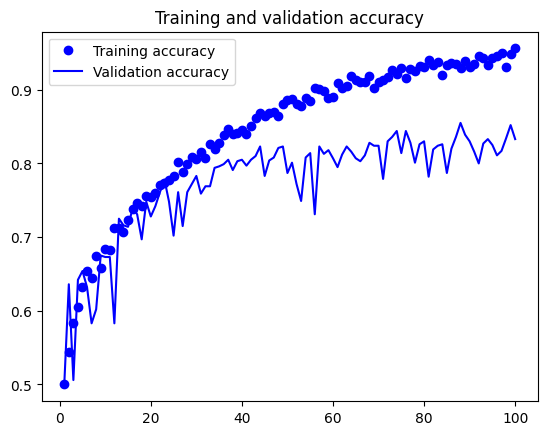

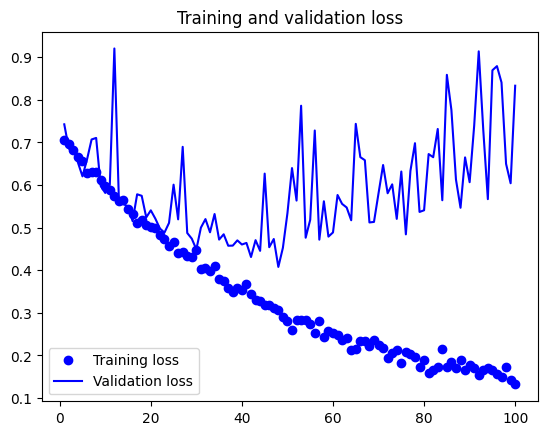

In [15]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Plottando anche in questo caso le curve, si può notare che le curve dell'accuracy sono molto più vicine tra loro, rispetto alla baseline, così come per le curve della loss, dove si crea meno apertura rispetto a prima. **In generale, si può notare come, con l'utilizzo di Data Augmentation e Dropout, il modello va in overtfitting molto dopo (epoca 50) rispetto alla baseline (epoca 10)**. **I miglioramenti si sono avuti anche nell'accurcay della validation, costante sull'80/82% rispetto i scarsi 75% di prima**. Quindi si è avuto un bel miglioramento rispetto la baseline, utilizzando semplicemente due tecniche di overfitting mitigation.

In [16]:
test_model = keras.models.load_model(
  "convnet_from_scratch_with_augmentation.keras")

test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8133 - loss: 0.4404
Test accuracy: 0.811


**Infine, anche sul test set si hanno miglioramenti, con 81% di accuracy, rispetto il 72% della baseline.**

Questo quindi, dimostra uno dei metodi più veloci e semplici per migliorare le prestazioni del nostro modello, mitigando l'overfitting e senza fare grosse modifiche alla nostra baseline originale.

Nei seguenti notebook invece, punteremo a migliorare ancor di più le prestazioni del nostro modello utilizzando tecniche più avanzate.